# Model Trainer

This notebook will take our image located at base directory, train a model, and then test the performance of that model.

In [4]:
#Import packages
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import random
import shutil
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import inspect
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight

#Load Tensorboard
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))
HOME_DIR = "/home/billiam/Documents/Repos/Lego-Brick-Sorter/"
os.chdir(HOME_DIR)
print(os.getcwd())

tf.Tensor(-566.8938, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/home/billiam/Documents/Repos/Lego-Brick-Sorter


<br></br>
**DISTRIBUTE IMAGES TO TRAINING, VALIDATION, AND TEST FOLDERS**

In [6]:
BASE_DIR = "/home/billiam/Documents/Lego_Sorter/Self Contained Synthetic Data Generation/Renders/"
print(BASE_DIR)

file = open(HOME_DIR + "finalPieceList.txt")
names = [line.rstrip("\n") for line in file.readlines()]

percentTraining = 0.6
percentValidation = 0.25

#Test set is defined as 0% since we will be using our own real images to test model in end, rather than synthetic data

tf.random.set_seed(1)
print("Length of names: ", len(names))
#print(list(names))

/home/billiam/Documents/Lego_Sorter/Self Contained Synthetic Data Generation/Renders/
Length of names:  1593


In [7]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)
        
# Move the image files
orig_folders = [name + "/" for name in names]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * percentTraining) + 0.5)
    n_valid = int((number_of_images* percentValidation) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


<br></br>
**CREATE OUR PRE-TRAINED MODEL WITH ONLY A FINAL TRAINABLE LAYER**

In [8]:
# From our tests, ResNet50 performed the best
pre_model = tf.keras.applications.ResNet50(include_top=False)
preprocess_fxn = tf.keras.applications.resnet50.preprocess_input
pre_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [9]:
# Compile our pre-trained model without last layer with a single trainable final layer

NUM_CLASSES = len(names)
print(NUM_CLASSES)
batchSize = 32

# Create our empty model (look up sequential vs functional)
model = keras.models.Sequential()

# Add all layers from our pre-trained model (last layer already deleted from include_top=False)
model.add(pre_model)

# Make all remaining layers untrainable
for layer in model.layers:
    layer.trainable = False

# Add our trainable layers
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(2048, activation='relu')) # Dense layer for combining features model recognized in img
model.add(layers.Dropout(0.5)) # Dropout layer which may prevent overfitting and improve generalization ability (test-set)
model.add(layers.Dense(NUM_CLASSES, activation='softmax')) # Final classification layer equal to number of classes

# Loss and optimizer functions
loss = keras.losses.CategoricalCrossentropy()
optim = keras.optimizers.Adam(learning_rate=0.0001)

# Might try mean average precision for metric because we are categorizing so many classes
metrics = ["categorical_accuracy", "top_k_categorical_accuracy"]

# Used to do accuracy but someone online recommended MAP
# https://www.reddit.com/r/learnmachinelearning/comments/xpyv8j/data_set_for_lego_image_classification_800000/
# metrics = ["accuracy"]

# Compile our model
model.compile(optimizer=optim, loss=loss, metrics=metrics)

model.summary()

1593
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1593)              3264057   
                                                                 
Total params: 31,048,121
Trainable params: 7,460,409
Non-trainable params: 23,587,712
_______________________________

<br></br>
**CREATE TENSORFLOW IMAGE DATA BATCHES WITH PREPROCESSING AND TRAIN OUR MODEL**

In [10]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn,
                                                        horizontal_flip = True,
                                                        vertical_flip = True,
                                                        rotation_range = 360,
                                                        channel_shift_range=50.0,
                                                        fill_mode = 'wrap'
                                                        )
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn)

train_batches = train_gen.flow_from_directory(
    BASE_DIR + 'train',
    target_size=(224, 224),
    batch_size=batchSize,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR + 'val',
    target_size=(224, 224),
    batch_size=batchSize,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

epochs = 100

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

print("Start training:")
history = model.fit(train_batches,
                    validation_data=val_batches,
                    callbacks=[early_stopping],
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    use_multiprocessing=True,
                    workers=16)

model.save("/home/billiam/Documents/Lego_Sorter/Self Contained Synthetic Data Generation/Models/" + "secondModel.h5")

Found 955800 images belonging to 1593 classes.
Found 398250 images belonging to 1593 classes.
Start training:
Epoch 1/100
29869/29869 [==============================] - 3027s 101ms/step - loss: 3.3592 - categorical_accuracy: 0.2787 - top_k_categorical_accuracy: 0.5229 - val_loss: 1.9516 - val_categorical_accuracy: 0.5018 - val_top_k_categorical_accuracy: 0.7792
Epoch 2/100
29869/29869 [==============================] - 3051s 102ms/step - loss: 2.3021 - categorical_accuracy: 0.4325 - top_k_categorical_accuracy: 0.7115 - val_loss: 1.6286 - val_categorical_accuracy: 0.5696 - val_top_k_categorical_accuracy: 0.8317
Epoch 3/100
29869/29869 [==============================] - 3026s 101ms/step - loss: 2.0391 - categorical_accuracy: 0.4828 - top_k_categorical_accuracy: 0.7594 - val_loss: 1.4664 - val_categorical_accuracy: 0.6030 - val_top_k_categorical_accuracy: 0.8564
Epoch 4/100
29869/29869 [==============================] - 3018s 101ms/step - loss: 1.9089 - categorical_accuracy: 0.5093 - top_

In [15]:
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn)

test_batches = test_gen.flow_from_directory(
    BASE_DIR + 'test',
    target_size=(224, 224),
    #class_mode='sparse',
    batch_size=batchSize,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

print("Performance:")
#model.evaluate(test_batches, verbose=2)

Found 15000 images belonging to 100 classes.
Performance:


AttributeError: 'DirectoryIterator' object has no attribute 'shape'

# TESTING DIFFERENT BATCH SIZE AND DENSE LAYER SIZES HERE

In [ ]:
# HERE WE WILL TEST THE DIFFERENT BATCH SIZES AND DENSE LAYER SIZES:
# Compile our pre-trained model without last layer with a single trainable final layer

#Varied sizes:
#batchSizes = [8, 16, 32, 64, 128]
batchSizes = [16, 32, 64]
learningRate = [0.0001]

for batch in batchSizes:
    for rate in learningRate:
        print("Batch size of: ", batch)
        print("Learning rate of: ", rate)
        
        NUM_CLASSES = len(names)
        #print(NUM_CLASSES)
        batchSize = batch

        # Create our empty model (look up sequential vs functional)
        model = keras.models.Sequential()

        # Add all layers from our pre-trained model (last layer already deleted from include_top=False)
        model.add(pre_model)

        # Make all remaining layers untrainable
        for layer in model.layers:
            layer.trainable = False

        # Add our trainable layers
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(2048, activation='relu')) # Dense layer for combining features model recognized in img
        model.add(layers.Dropout(0.5)) # Dropout layer which may prevent overfitting and improve generalization ability (test-set)
        model.add(layers.Dense(NUM_CLASSES, activation='softmax')) # Final classification layer equal to number of classes

        # Loss and optimizer functions
        loss = keras.losses.CategoricalCrossentropy()
        optim = keras.optimizers.Adam(learning_rate=rate)

        # Might try mean average precision for metric because we are categorizing so many classes
        metrics = ["categorical_accuracy", "top_k_categorical_accuracy"]

        # Used to do accuracy but someone online recommended MAP
        # https://www.reddit.com/r/learnmachinelearning/comments/xpyv8j/data_set_for_lego_image_classification_800000/
        # metrics = ["accuracy"]

        # Compile our model
        model.compile(optimizer=optim, loss=loss, metrics=metrics)

        #model.summary()

        train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn,
                                                                horizontal_flip = True,
                                                                vertical_flip = True,
                                                                rotation_range = 360,
                                                                channel_shift_range=50.0,
                                                                fill_mode = 'wrap'
                                                                )
        valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn)
        test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn)

        train_batches = train_gen.flow_from_directory(
            BASE_DIR + 'train',
            target_size=(224, 224),
            batch_size=batchSize,
            shuffle=True,
            color_mode="rgb",
            classes=names   
        )

        val_batches = valid_gen.flow_from_directory(
            BASE_DIR + 'val',
            target_size=(224, 224),
            batch_size=batchSize,
            shuffle=True,
            color_mode="rgb",
            classes=names
        )

        early_stopping = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            verbose=2
        )

        test_batches = test_gen.flow_from_directory(
            BASE_DIR + 'test',
            target_size=(224, 224),
            #class_mode='sparse',
            batch_size=batchSize,
            shuffle=False,
            color_mode="rgb",
            classes=names
        )

        print("Start training:")
        history = model.fit(train_batches,
                            validation_data=val_batches,
                            callbacks=[early_stopping],
                            epochs=3,
                            verbose=1,
                            shuffle=True,
                            use_multiprocessing=True,
                            workers=16)

        # model.save("/home/billiam/Documents/Lego_Sorter/Self Contained Synthetic Data Generation/Models/" + "firstModel.h5")

        print("Performance:")
        model.evaluate(test_batches, verbose=2)

Batch size of:  16
Learning rate of:  0.0001
Found 955800 images belonging to 1593 classes.
Found 398250 images belonging to 1593 classes.
Found 238950 images belonging to 1593 classes.
Start training:
Epoch 1/3
59738/59738 [==============================] - 3377s 56ms/step - loss: 3.3279 - categorical_accuracy: 0.2787 - top_k_categorical_accuracy: 0.5271 - val_loss: 1.9524 - val_categorical_accuracy: 0.4983 - val_top_k_categorical_accuracy: 0.7785
Epoch 2/3
59738/59738 [==============================] - 3371s 56ms/step - loss: 2.3933 - categorical_accuracy: 0.4163 - top_k_categorical_accuracy: 0.6971 - val_loss: 1.7081 - val_categorical_accuracy: 0.5500 - val_top_k_categorical_accuracy: 0.8187
Epoch 3/3
59738/59738 [==============================] - 3336s 56ms/step - loss: 2.2140 - categorical_accuracy: 0.4511 - top_k_categorical_accuracy: 0.7311 - val_loss: 1.5885 - val_categorical_accuracy: 0.5749 - val_top_k_categorical_accuracy: 0.8381
Performance:
14935/14935 - 593s - loss: 1.591

<br></br>

In [23]:
# Testing predict:
path = "/home/billiam/Documents/Repos/Lego-Brick-Sorter/Imaging Pipeline/exampleBatches/4_9.jpg"
loaded = tf.keras.utils.load_img(path, target_size=(224,224))
img_array = tf.keras.utils.img_to_array(loaded)
img_array = tf.expand_dims(img_array,0)
predictions = model.predict(img_array)

1/1 [==============================] - 2s 2s/step


In [26]:
prediction_probabilities = tf.math.top_k(predictions, k = 4)
top_5_scores = prediction_probabilities.values.numpy()
top_5_indices = prediction_probabilities.indices.numpy()
print(top_5_scores)
print(top_5_indices)
print(predictions)

[[1.0000000e+00 8.9058394e-10 6.9284344e-24 3.7420572e-26]]
[[2 3 1 0]]
[[3.7420572e-26 6.9284344e-24 1.0000000e+00 8.9058394e-10]]


In [50]:
#model = tf.keras.models.load_model(HOME_DIR + "full_synthetic_model")


def show(batch, num, pred_labels=None):
    for _ in range(num):
        img, label = batch.next()
        print(img.shape)
        print(type(img))
        clipFactor = img[0]/np.amax(img[0])
        clippedImg = np.clip(clipFactor, 0, 1)
        plt.imshow(clippedImg)
        plt.show()

(4, 224, 224, 3)
<class 'numpy.ndarray'>


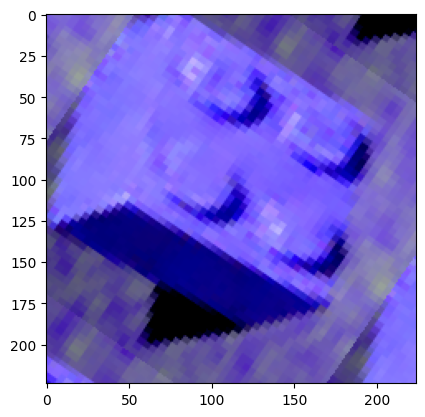

(4, 224, 224, 3)
<class 'numpy.ndarray'>


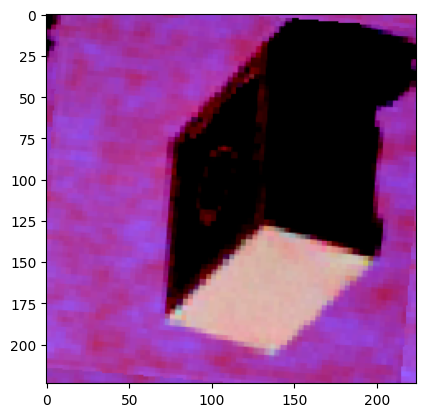

(4, 224, 224, 3)
<class 'numpy.ndarray'>


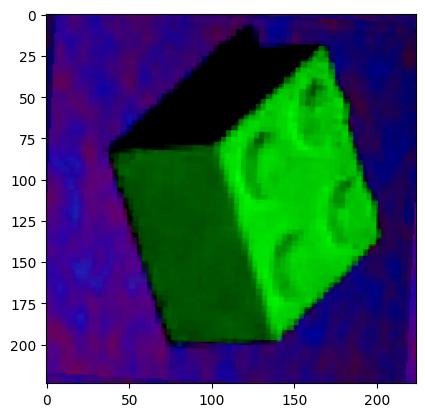

(4, 224, 224, 3)
<class 'numpy.ndarray'>


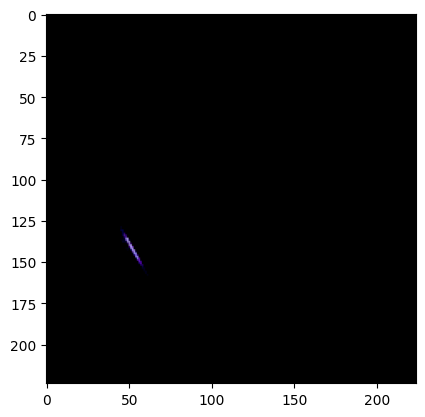

(4, 224, 224, 3)
<class 'numpy.ndarray'>


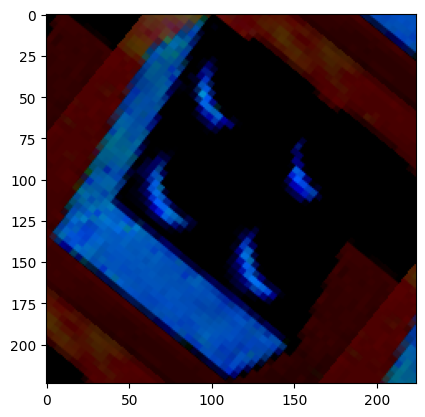

(4, 224, 224, 3)
<class 'numpy.ndarray'>


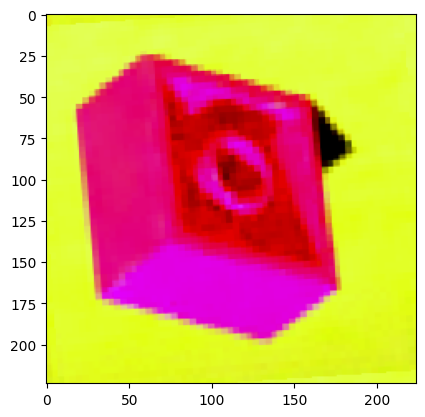

(4, 224, 224, 3)
<class 'numpy.ndarray'>


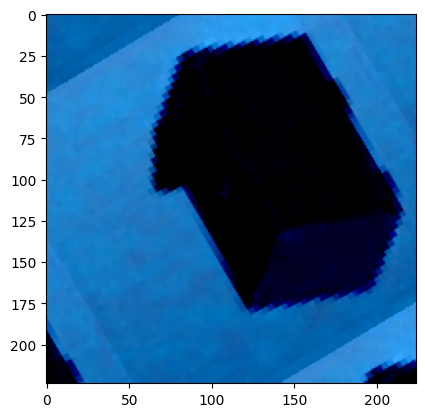

(4, 224, 224, 3)
<class 'numpy.ndarray'>


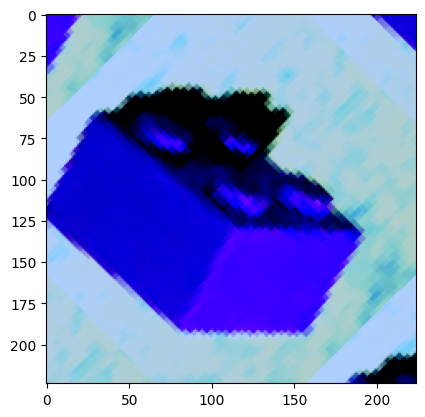

(4, 224, 224, 3)
<class 'numpy.ndarray'>


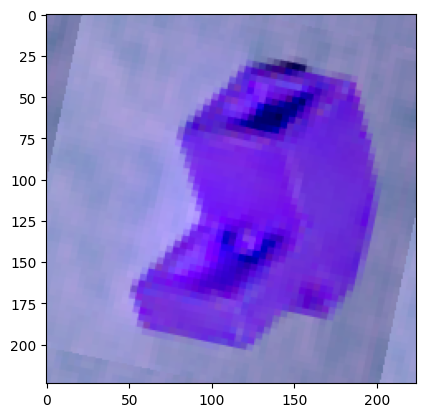

(4, 224, 224, 3)
<class 'numpy.ndarray'>


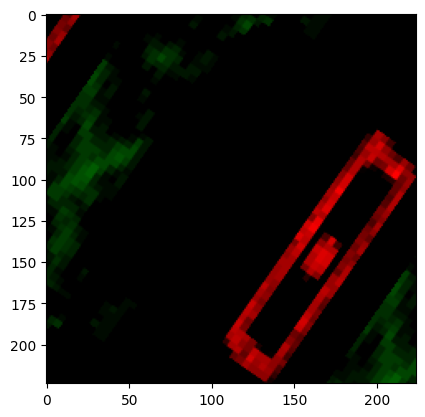

(4, 224, 224, 3)
<class 'numpy.ndarray'>


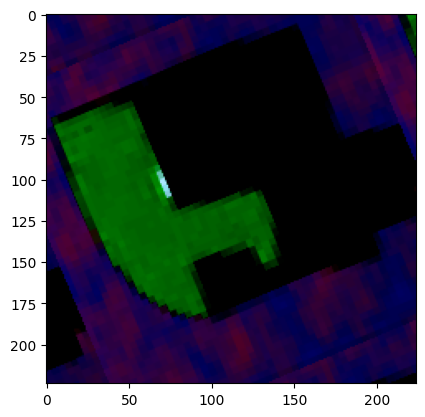

(4, 224, 224, 3)
<class 'numpy.ndarray'>


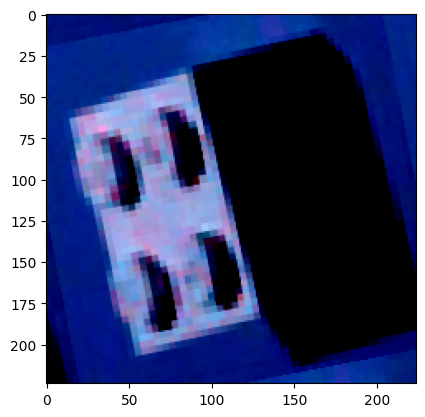

(4, 224, 224, 3)
<class 'numpy.ndarray'>


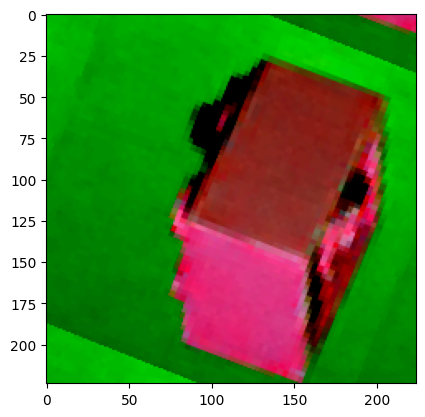

(4, 224, 224, 3)
<class 'numpy.ndarray'>


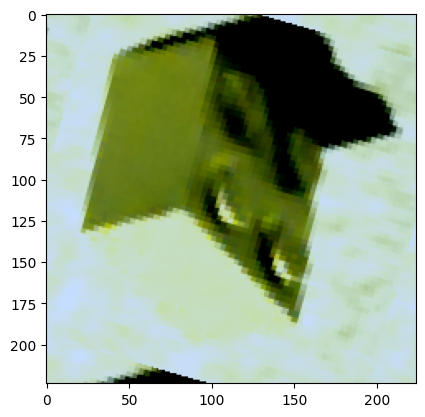

(4, 224, 224, 3)
<class 'numpy.ndarray'>


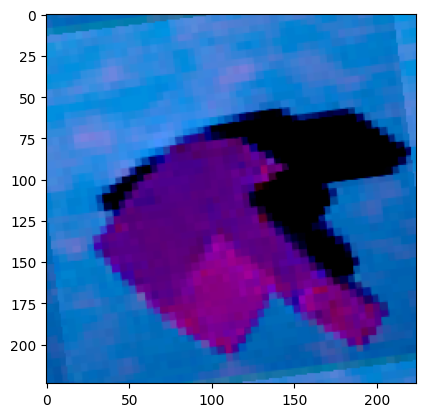

(4, 224, 224, 3)
<class 'numpy.ndarray'>


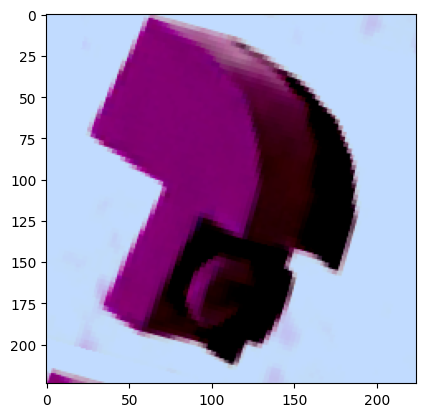

(4, 224, 224, 3)
<class 'numpy.ndarray'>


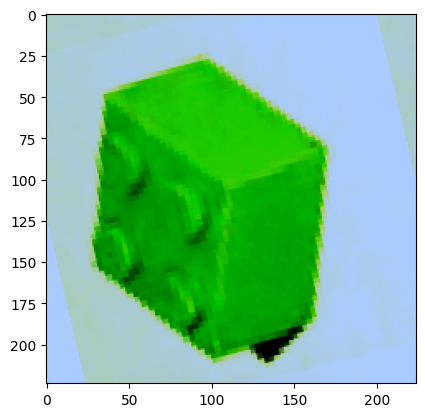

(4, 224, 224, 3)
<class 'numpy.ndarray'>


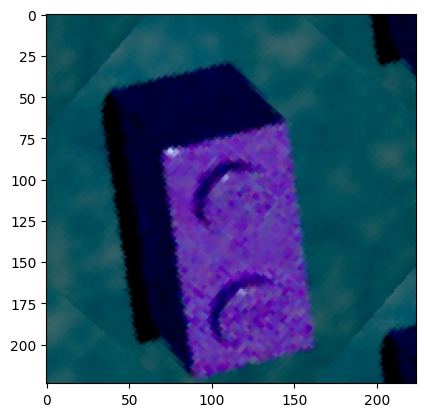

(4, 224, 224, 3)
<class 'numpy.ndarray'>


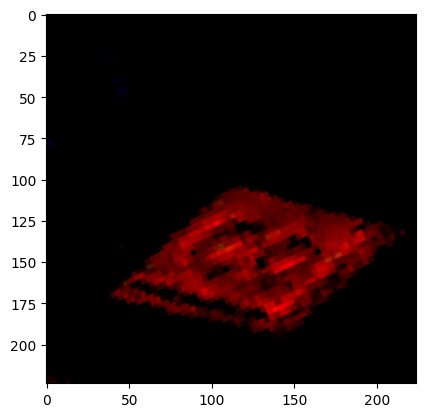

(4, 224, 224, 3)
<class 'numpy.ndarray'>


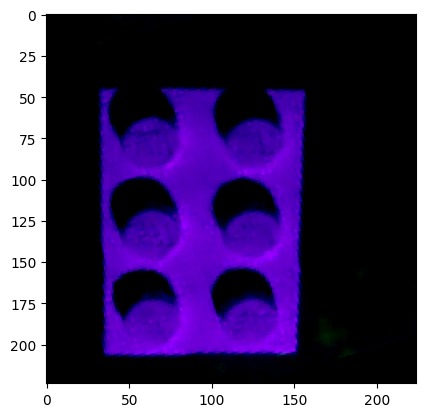

In [51]:
show(train_batches, 20)

# Fine Tuning Our Model

**Take our base pre-trained model (DenseNet169) and turn all of its layers except the last couple to be trainable. Set a lower learning rate since we are fine tuning, and then compile our whole model with a diferent pre_model**

In [73]:
pre_model.trainable = True
for layer in pre_model.layers:
    # Boolean whether this layer is trainable (conv4 or conv5)
    trainable = ('conv4' in layer.name or 'conv5' in layer.name)
    
    # Set trainable of conv4 or conv5
    layer.trainable = trainable

# Loss and optimizer functions
loss_fine = keras.losses.CategoricalCrossentropy()
optim_fine = keras.optimizers.Adam(learning_rate=0.00001) #Lower learning rate since fine tuning

# Might try mean average precision for metric because we are categorizing so many classes
metrics_fine = ["categorical_accuracy"]

model.compile(optimizer=optim_fine, loss=loss_fine, metrics=metrics_fine)

<br></br>
**Distribute Real Images to Folders and Generate Image Generator Batches**

In [74]:
#ORGANIZE OUR FOLDERS WITH OUR REAL IMAGES

BASE_DIR = HOME_DIR + 'data/realData/'
print(BASE_DIR)
names = ["3003", "3004", "3021", "6091"]
percentTraining = 0.6
percentValidation = 0.25

tf.random.set_seed(1)

# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)
        
# Move the image files
orig_folders = [name + "/" for name in names]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * percentTraining) + 0.5)
    n_valid = int((number_of_images* percentValidation) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

/home/billiam/Documents/Repos/Lego-Brick-Sorter/data/realData/
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


In [75]:
train_batches = train_gen.flow_from_directory(
    BASE_DIR + 'train',
    target_size=(224, 224),
    #class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR + 'val',
    target_size=(224, 224),
    #class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

Found 841 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


<br></br>
**Compute Class Weights and Fit Our Model**

In [76]:
# Since our real data sets are most likely unbalanced, create class weights for each of our different classes
# e.g. Less 2x4 images will mean the model will learn more from the limited amount of images
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(train_batches.classes),
                                    y=train_batches.classes)
class_weight = {i : class_weight[i] for i in range(len(names))}
print(class_weight)

print("Start training:")
history_fine = model.fit(train_batches,
                         validation_data=val_batches,
                         callbacks=[early_stopping],
                         epochs=epochs,
                         verbose=2,
                         shuffle=True,
                        class_weight=class_weight)

{0: 2.595679012345679, 1: 0.3264751552795031, 2: 2.8801369863013697, 3: 4.8895348837209305}
Start training:
Epoch 1/25
211/211 - 25s - loss: 0.7700 - categorical_accuracy: 0.7122 - val_loss: 0.5388 - val_categorical_accuracy: 0.7806 - 25s/epoch - 116ms/step
Epoch 2/25
211/211 - 15s - loss: 0.4848 - categorical_accuracy: 0.7396 - val_loss: 0.6493 - val_categorical_accuracy: 0.7464 - 15s/epoch - 70ms/step
Epoch 3/25
211/211 - 15s - loss: 0.3820 - categorical_accuracy: 0.8395 - val_loss: 0.5622 - val_categorical_accuracy: 0.7778 - 15s/epoch - 70ms/step
Epoch 4/25
211/211 - 15s - loss: 0.3938 - categorical_accuracy: 0.7979 - val_loss: 0.2432 - val_categorical_accuracy: 0.9060 - 15s/epoch - 69ms/step
Epoch 5/25
211/211 - 15s - loss: 0.3552 - categorical_accuracy: 0.8395 - val_loss: 0.3465 - val_categorical_accuracy: 0.8575 - 15s/epoch - 70ms/step
Epoch 6/25
211/211 - 15s - loss: 0.2126 - categorical_accuracy: 0.8799 - val_loss: 0.1835 - val_categorical_accuracy: 0.9373 - 15s/epoch - 70ms/st

<br></br>
**Evaluate our model**

In [77]:
test_batches = test_gen.flow_from_directory(
    BASE_DIR + 'test',
    target_size=(224, 224),
    #class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

print("Performance:")
model.evaluate(test_batches, verbose=2)

Found 209 images belonging to 4 classes.
Performance:
53/53 - 2s - loss: 0.1802 - categorical_accuracy: 0.9330 - 2s/epoch - 29ms/step


[0.18015287816524506, 0.9330143332481384]

<br></br>
**Save our model**

In [78]:
model.save(HOME_DIR + "models/" + "full_synthetic_model_with_RW_finetuning_93.3%")

INFO:tensorflow:Assets written to: /home/billiam/Documents/Repos/Lego-Brick-Sorter/models/full_synthetic_model_with_RW_finetuning_93.3%/assets


INFO:tensorflow:Assets written to: /home/billiam/Documents/Repos/Lego-Brick-Sorter/models/full_synthetic_model_with_RW_finetuning_93.3%/assets
